In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import pandas as pd 

# Задаём параметры
n_total = 100_000
fraud_ratio = 0.005  # 0.5%
n_fraud = int(n_total * fraud_ratio)
n_legit = n_total - n_fraud
# Создаём таргет
y_true = np.array([1]*n_fraud + [0]*n_legit)

In [4]:
# Генерируем скоres:
# - фрод получает вероятности от 0.6 до 1.0
# - обычные транзакции — от 0.0 до 0.4
fraud_scores = np.random.uniform(0.6, 1.0, size=n_fraud)
legit_scores = np.random.uniform(0.0, 0.4, size=n_legit)
y_scores = np.concatenate([fraud_scores, legit_scores])

In [5]:
# Перемешаем
shuffled = np.random.permutation(n_total)
y_true = y_true[shuffled]
shuffled = np.random.permutation(n_total)
y_scores = y_scores[shuffled]

In [6]:
check = pd.DataFrame({'pred':y_scores,'target':y_true})
#check[(check['target']==0)&(check['pred']>0.5)]

In [7]:
pr_auc = average_precision_score(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

In [8]:
# Precision-Recall кривая
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [9]:
# Precision@k: top 0.1% предсказаний
k = int(0.001 * n_total)  # top 0.1% (100 объектов)
top_k_indices = np.argsort(y_scores)[-k:]
precision_at_k = np.mean(y_true[top_k_indices])

roc_auc, pr_auc, precision_at_k

(0.5073370854271357, 0.005125247061940125, 0.0)

In [10]:
treshhold = 0.5
TP = check[(check['target']==1)&(check['pred']>=treshhold)].shape[0]
TN = check[(check['target']==0)&(check['pred']<treshhold)].shape[0]
FP = check[(check['target']==0)&(check['pred']>=treshhold)].shape[0]
FN = check[(check['target']==1)&(check['pred']<treshhold)].shape[0]
Pr = TP/(TP+FP)
Recall = TP/(TP+FN)
print(Pr)
print(Recall)

0.008
0.008


In [11]:
# Создадим ситуацию, когда ROC AUC ≈ 0.99, но precision@top-K ≈ 0

# Новая схема:
# - Пусть фроды по-прежнему 0.5% (редкий класс)
# - Фроды получают скоры от 0.6 до 1.0 (высокие, но не самые высокие)
# - Легитимные получают: 
#   - 99% из них — от 0.0 до 0.4 (низкие, как надо)
#   - 1% — от 0.95 до 1.0 (высоченные! попадают в top-K, создавая фальшивое качество)

# Таким образом: модель хорошо ранжирует в целом, но в top-K — шум

# Новое распределение
legit_majority = int(n_legit * 0.99)
legit_tail = n_legit - legit_majority

legit_scores_main = np.random.uniform(0.0, 0.4, size=legit_majority)
legit_scores_tail = np.random.uniform(0.95, 1.0, size=legit_tail)
fraud_scores = np.random.uniform(0.6, 0.9, size=n_fraud)

y_true = np.array([1]*n_fraud + [0]*legit_majority + [0]*legit_tail)
y_scores = np.concatenate([fraud_scores, legit_scores_main, legit_scores_tail])

# Перемешиваем
indices = np.random.permutation(len(y_true))
y_true = y_true[indices]
y_scores = y_scores[indices]

# Считаем метрики
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
top_k_indices = np.argsort(y_scores)[-k:]
precision_at_k = np.mean(y_true[top_k_indices])

roc_auc, pr_auc, precision_at_k

(0.99, 0.19012824500816447, 0.0)

In [12]:
N = 100000
r_true =0.01
r_tail = 0.9

N_true = N*r_true
N_tail = int(round((N_true*r_tail),0))
N_head = int(round((N_true*(1-r_tail)),0))
N_main = N - N_tail - N_head

y_true = np.array([1]*N_head + [0]*(N_main) + [1]*N_tail)

scores_main = np.random.uniform(0.3, 0.9, size=N_main)
scores_tail = np.random.uniform(0.0, 0.3, size=N_tail)
scores_head = np.random.uniform(0.95, 1.0, size=N_head)
y_scores = np.concatenate([scores_head, scores_main, scores_tail])

# Считаем метрики
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
top_k_indices = np.argsort(y_scores)[-k:]
precision_at_k = np.mean(y_true[top_k_indices])

roc_auc, pr_auc, precision_at_k

(0.1, 0.10497077488132213, 1.0)

In [13]:
check = pd.DataFrame({'pred':y_scores,'target':y_true}).sort_values(by='pred',ascending = False)

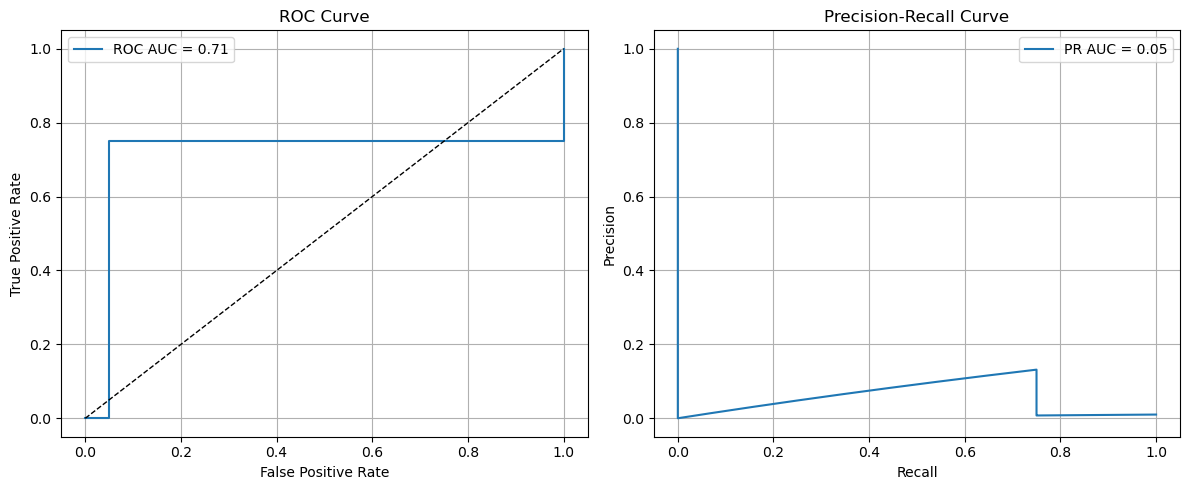

precision_at_k 0.0
roc_auc 0.7124999999999999
pr_auc 0.053918072951977966


In [14]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

# Таргет будет собираться вот такой схемой [0,1,0,1]
# При этом количестов 0 и 1 будет вариативно[10%,90%,10%,90%]
t =[0,1,0,1]
pos_head = 0.75
neg_head =0.05

resp = [neg_head,pos_head,1-neg_head,1-pos_head]
N = 100000
r_true =0.01
r_tail = 0.1

N_t = int(N*r_true)
N_f = int(N-N_t)
resp_n = [int(N_f*resp[0]),int(N_t*resp[1]),int(N_f*resp[2]),int(N_t*resp[3])]
y_true = np.array([0]*resp_n[0] +[1]*resp_n[1] + [0]*resp_n[2] + [1]*resp_n[3])
scores_1= np.random.uniform(0.95, 1.0, size=resp_n[0])
scores_2 = np.random.uniform(0.5, 0.9, size=resp_n[1])
scores_3 = np.random.uniform(0.3, 0.5, size=resp_n[2])
scores_4 = np.random.uniform(0.0, 0.3, size=resp_n[3])
y_scores = np.concatenate([scores_1, scores_2, scores_3,scores_4])
# Считаем метрики
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
top_k_indices = np.argsort(y_scores)[-k:]
precision_at_k = np.mean(y_true[top_k_indices])

roc_auc, pr_auc, precision_at_k# ROC и PR кривые
fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axs[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set_title('ROC Curve')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid(True)

# PR Curve
axs[1].plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
axs[1].set_title('Precision-Recall Curve')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

print(f'precision_at_k {precision_at_k}')
print(f'roc_auc {roc_auc}')
print(f'pr_auc {pr_auc}')

In [15]:
import matplotlib.pyplot as plt
def plot_scatter_probs(y_true, y_scores, title="Scatter: предсказания vs класс"):
    plt.figure(figsize=(6, 5))
    plt.scatter(y_scores, y_true, alpha=0.3)
    plt.xlabel("Предсказанная вероятность")
    plt.ylabel("Истинный класс")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

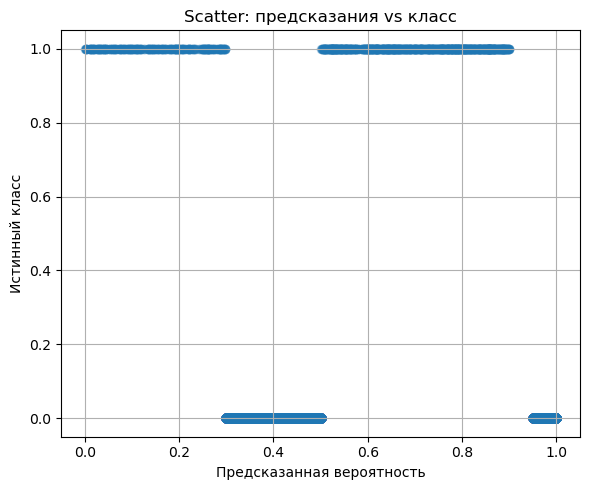

In [16]:
plot_scatter_probs(y_true, y_scores)

In [17]:
def plot_calibration_curve(y_true, y_scores, title="Калибровка модели"):
    import matplotlib.pyplot as plt
    from sklearn.calibration import calibration_curve
    from sklearn.metrics import brier_score_loss, log_loss
    
    prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
    brier = brier_score_loss(y_true, y_scores)
    logloss = log_loss(y_true, y_scores)
    
    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label='Модель')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеал')
    plt.xlabel("Предсказанная вероятность")
    plt.ylabel("Фактическая доля положительных")
    plt.title(f"{title}\nBrier = {brier:.3f}, LogLoss = {logloss:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

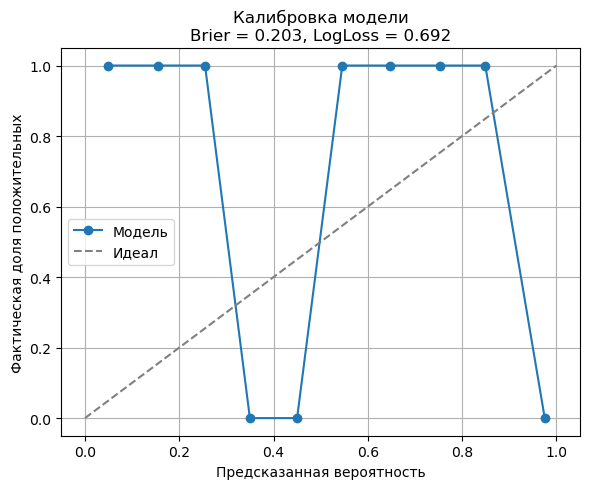

In [18]:
plot_calibration_curve(y_true, y_scores)

In [19]:
def plot_logloss_by_bins(y_true, y_scores, title="Log Loss по бинам вероятностей", bins=10):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import log_loss
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_ids = np.digitize(y_scores, bin_edges) - 1
    logloss_per_bin = [log_loss(y_true[bin_ids == i], y_scores[bin_ids == i], labels=[0, 1]) if np.any(bin_ids == i) else 0 for i in range(bins)]
    plt.figure(figsize=(7, 5))
    plt.bar(range(bins), logloss_per_bin, width=0.8,
    tick_label=[f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}" for i in range(bins)])
    plt.xlabel("Бины предсказанной вероятности")
    plt.ylabel("Log Loss")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

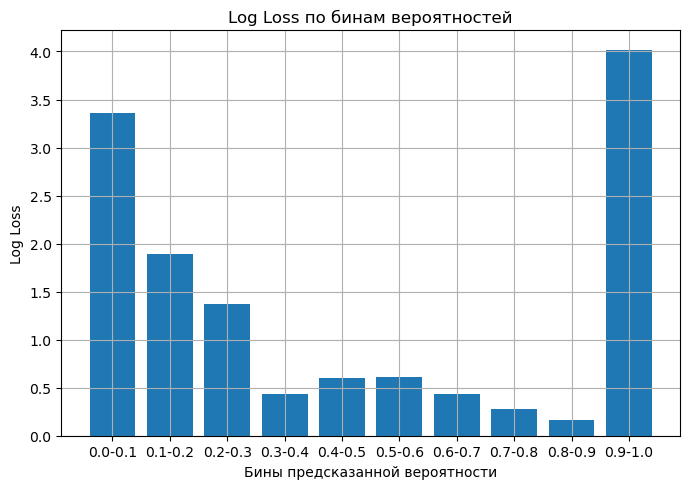

In [20]:
plot_logloss_by_bins(y_true, y_scores)